# Matrix Multiplication Benchmark — Full Analysis
This notebook performs a full analysis of your dense and sparse benchmark data:
- Dense method comparison
- Sparse method comparison
- Speedup of Sparse vs Dense
- Log‑scale time plots
- Memory usage analysis
- Per‑size and per‑sparsity breakdowns


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dense = pd.read_csv('dense_results.csv', encoding='latin1')
sparse = pd.read_csv('sparse_results.csv', encoding='latin1')
dense.head(), sparse.head()

(   size            method  avg_time  std_time  min_time  max_time  \
 0    10       Basic O(n³)  0.000222  0.000039  0.000171  0.000267   
 1    10      NumPy (BLAS)  0.000006  0.000006  0.000002  0.000015   
 2    10          Strassen  0.000010  0.000003  0.000005  0.000013   
 3    10   Cache Optimized  0.000022  0.000013  0.000012  0.000040   
 4    10  Transpose Method  0.000364  0.000008  0.000356  0.000375   
 
    avg_memory_mb  max_memory_mb  
 0            0.0            0.0  
 1            0.0            0.0  
 2            0.0            0.0  
 3            0.0            0.0  
 4            0.0            0.0  ,
    size  sparsity  actual_sparsity         method  avg_time  std_time  \
 0   100      50.0            49.36     CSR Format  0.001151  0.000650   
 1   100      50.0            49.36     CSC Format  0.001173  0.000746   
 2   100      50.0            49.36  Dense (NumPy)  0.000167  0.000015   
 3   100      70.0            69.28     CSR Format  0.000383  0.000012 

## Dense — Avg Time vs Size (log scale)

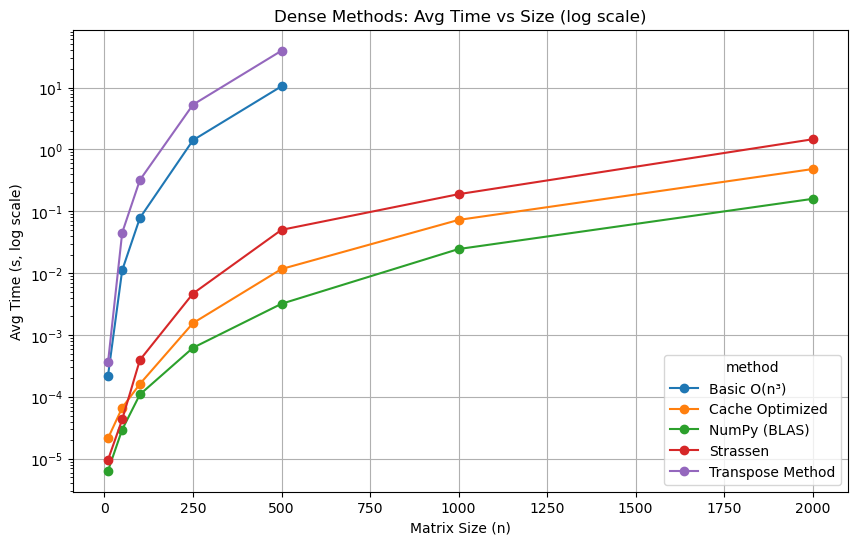

In [7]:
pivot = dense.pivot(index='size', columns='method', values='avg_time')
pivot.plot(marker='o', figsize=(10,6), logy=True)
plt.title('Dense Methods: Avg Time vs Size (log scale)')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Avg Time (s, log scale)')
plt.grid(True)
plt.show()

## Dense — Memory Usage

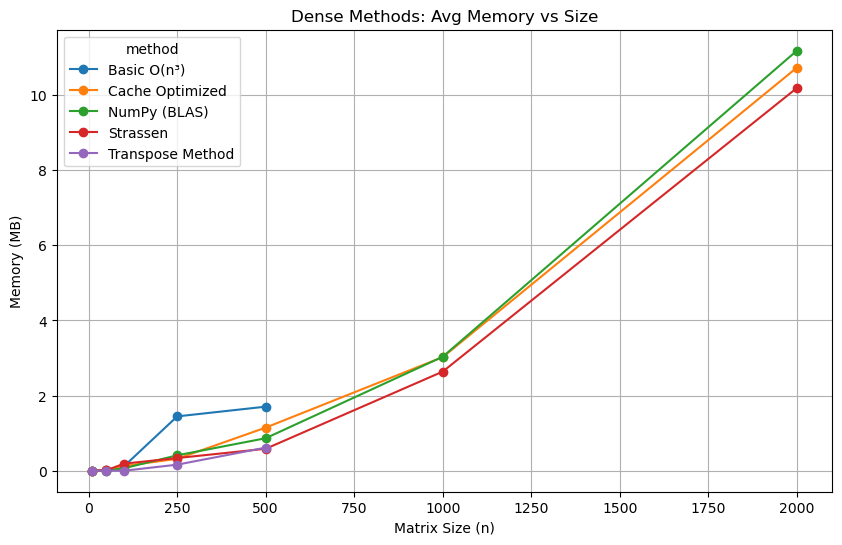

In [8]:
pivot_mem = dense.pivot(index='size', columns='method', values='avg_memory_mb')
pivot_mem.plot(marker='o', figsize=(10,6))
plt.title('Dense Methods: Avg Memory vs Size')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Memory (MB)')
plt.grid(True)
plt.show()

# Sparse — Per‑Size Analysis

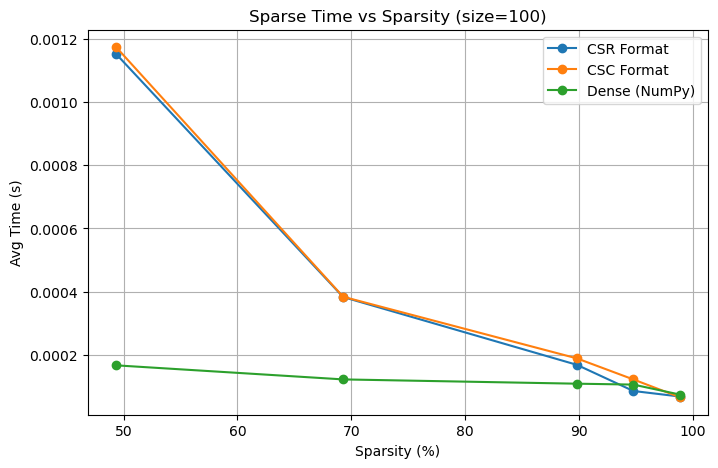

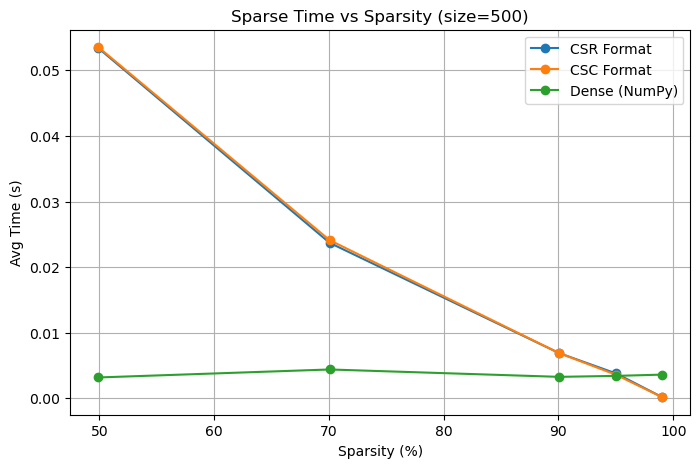

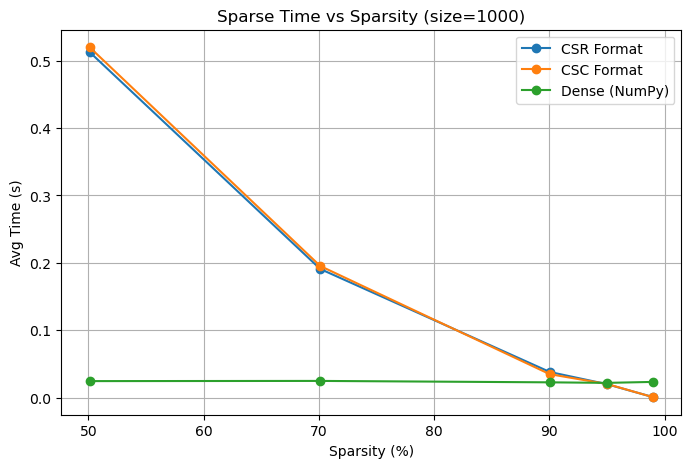

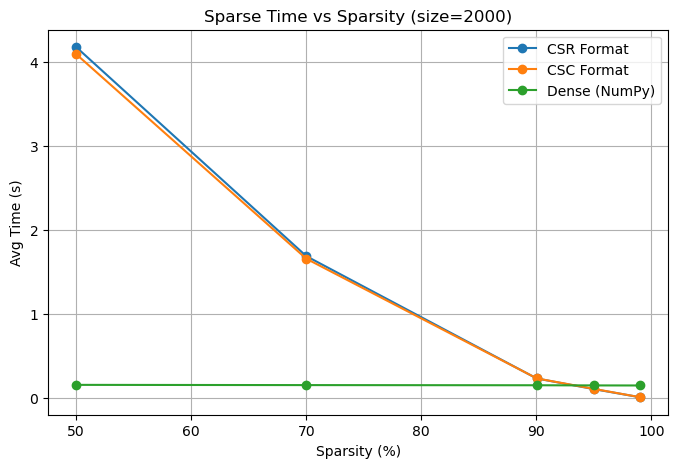

In [9]:
for size in sorted(sparse['size'].unique()):
    subset = sparse[sparse['size'] == size]
    plt.figure(figsize=(8,5))
    for method in subset['method'].unique():
        sub2 = subset[subset['method'] == method]
        plt.plot(sub2['actual_sparsity'], sub2['avg_time'], marker='o', label=method)
    plt.title(f'Sparse Time vs Sparsity (size={size})')
    plt.xlabel('Sparsity (%)')
    plt.ylabel('Avg Time (s)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Speedup: CSR vs Dense NumPy

In [11]:
speedup_records = []

for size in sorted(sparse['size'].unique()):
    for sp in sorted(sparse['actual_sparsity'].unique()):
        sub = sparse[(sparse['size']==size) & (sparse['actual_sparsity']==sp)]
        csr = sub[sub['method']=='CSR Format']['avg_time'].values
        dense_np = sub[sub['method']=='Dense (NumPy)']['avg_time'].values
        if len(csr)>0 and len(dense_np)>0:
            speedup = dense_np[0] / csr[0]
            speedup_records.append([size, sp, speedup])

speedup_df = pd.DataFrame(speedup_records, columns=['size','sparsity','speedup'])
speedup_df.head()

,size,sparsity,speedup
0,100,49.36,0.145442
1,100,69.28,0.320870
2,100,89.79,0.647349
3,100,94.75,1.234182
4,100,98.83,1.090514


## Plot Speedup (Dense / CSR)

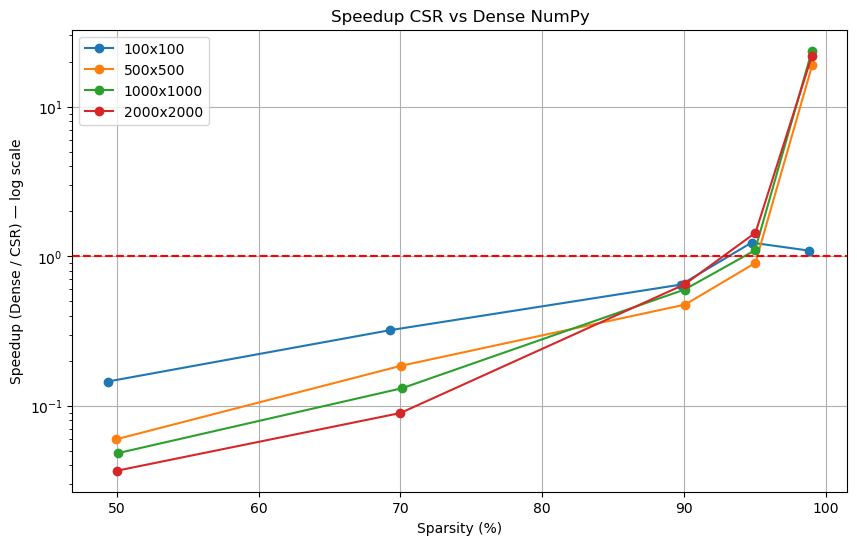

In [12]:
plt.figure(figsize=(10,6))
for size in speedup_df['size'].unique():
    ss = speedup_df[speedup_df['size']==size]
    plt.plot(ss['sparsity'], ss['speedup'], marker='o', label=f'{size}x{size}')

plt.axhline(1, color='red', linestyle='--')
plt.yscale('log')
plt.xlabel('Sparsity (%)')
plt.ylabel('Speedup (Dense / CSR) — log scale')
plt.title('Speedup CSR vs Dense NumPy')
plt.legend()
plt.grid(True)
plt.show()

# Summary Tables for Report

In [13]:
print('Dense Summary:')
display(dense.groupby('method')[['avg_time','avg_memory_mb']].agg(['mean','min','max']))

print('\nSparse Summary:')
display(sparse.groupby('method')[['avg_time','avg_memory_mb']].agg(['mean','min','max']))

Dense Summary:


avg_time                      avg_memory_mb                
                      mean       min        max          mean  min        max
method                                                                       
Basic O(n³)       2.395446  0.000222  10.477731      0.658854  0.0   1.705729
Cache Optimized   0.081106  0.000022   0.481670      2.193452  0.0  10.730469
NumPy (BLAS)      0.026791  0.000006   0.159000      2.222842  0.0  11.182292
Strassen          0.243262  0.000010   1.458383      1.993118  0.0  10.188802
Transpose Method  8.998310  0.000364  39.337591      0.155469  0.0   0.615885


Sparse Summary:


avg_time                     avg_memory_mb                
                   mean       min       max          mean  min        max
method                                                                   
CSC Format     0.347640  0.000067  4.091542      4.095182  0.0  15.260417
CSR Format     0.352747  0.000069  4.175719      4.158529  0.0  15.272135
Dense (NumPy)  0.044267  0.000075  0.153863      3.338542  0.0  10.173177